# Make logoplots showing key sites of escape for each antibody

In [5]:
import functools
import itertools
import operator
import os

import altair as alt

import dmslogo
import dmslogo.colorschemes

import matplotlib
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import yaml

_ = alt.data_transformers.disable_max_rows()
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
min_entry = -2
min_ACE2 = -2
n_sites_to_show = 10
specific_sites = [256, 417, 486, 505, 31]

In [9]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [14]:
summary = pd.read_csv(config['summary_csv'])

In [16]:
summary_melted = summary.melt(
    id_vars=[col for col in summary.columns if col not in ['infant sera escape', 'infant_post_vaccine sera escape', 'child sera escape', 'adult sera escape']],
    value_vars=['infant sera escape', 'infant_post_vaccine sera escape', 'child sera escape', 'adult sera escape'],
    var_name='sera_type',
    value_name='escape'
)

In [17]:
# Group by 'sera_type' and 'site' and sum the 'escape' values
grouped_summary = summary_melted.groupby(['sera_type', 'site'], as_index=False)['escape'].sum()

# Get the top n_sites_to_show rows based on 'escape' for each sera_type
top_n_sites = (
    grouped_summary.sort_values(['sera_type', 'escape'], ascending=[True, False])
    .groupby('sera_type')
    .head(n_sites_to_show)
)

# Get the rows where 'site' is in the specific_sites
specific_sites_rows = grouped_summary[grouped_summary['site'].isin(specific_sites)]

# Combine both sets of rows and drop duplicates
top_sites = (
    pd.concat([top_n_sites, specific_sites_rows])
    .drop_duplicates()
    .sort_values(['sera_type', 'escape'], ascending=[True, False])
    .reset_index(drop=True)
)

In [18]:
top_sites_list = top_sites['site'].unique() 

top_sites_set = set(top_sites_list)

summary_melted['show_site'] = summary_melted['site'].isin(top_sites_set)

In [19]:
summary_melted = summary_melted[summary_melted['ACE2 binding'].notna()]
summary_melted = summary_melted[summary_melted['spike mediated entry'].notna()]

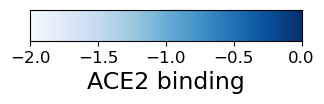

Saving to results/key_sites_ace2_scalebar_horizontal.svg


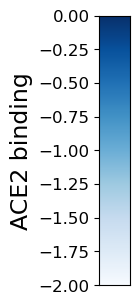

Saving to results/key_sites_ace2_scalebar_vertical.svg


In [23]:
# for coloring by ACE2
ace2_colormap = dmslogo.colorschemes.ValueToColorMap(
    minvalue=max(-2, summary_melted["ACE2 binding"].min()),
    maxvalue=0,
    cmap="Blues",
)

summary_melted["color"] = (
    summary_melted["ACE2 binding"]
    .clip(lower=ace2_colormap.minvalue, upper=ace2_colormap.maxvalue)
    .map(ace2_colormap.val_to_color)
)

for orientation in ["horizontal", "vertical"]:
    fig, _ = ace2_colormap.scale_bar(
        orientation=orientation, label="ACE2 binding",
    )
    display(fig)
    svg = os.path.join("results",f"key_sites_ace2_scalebar_{orientation}.svg")
    print(f"Saving to {svg}")
    fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

In [24]:
#replace deletion string - to X so that logoplots are scaled properly
summary_melted['mutant'] = summary_melted['mutant'].str.replace('-', 'X')

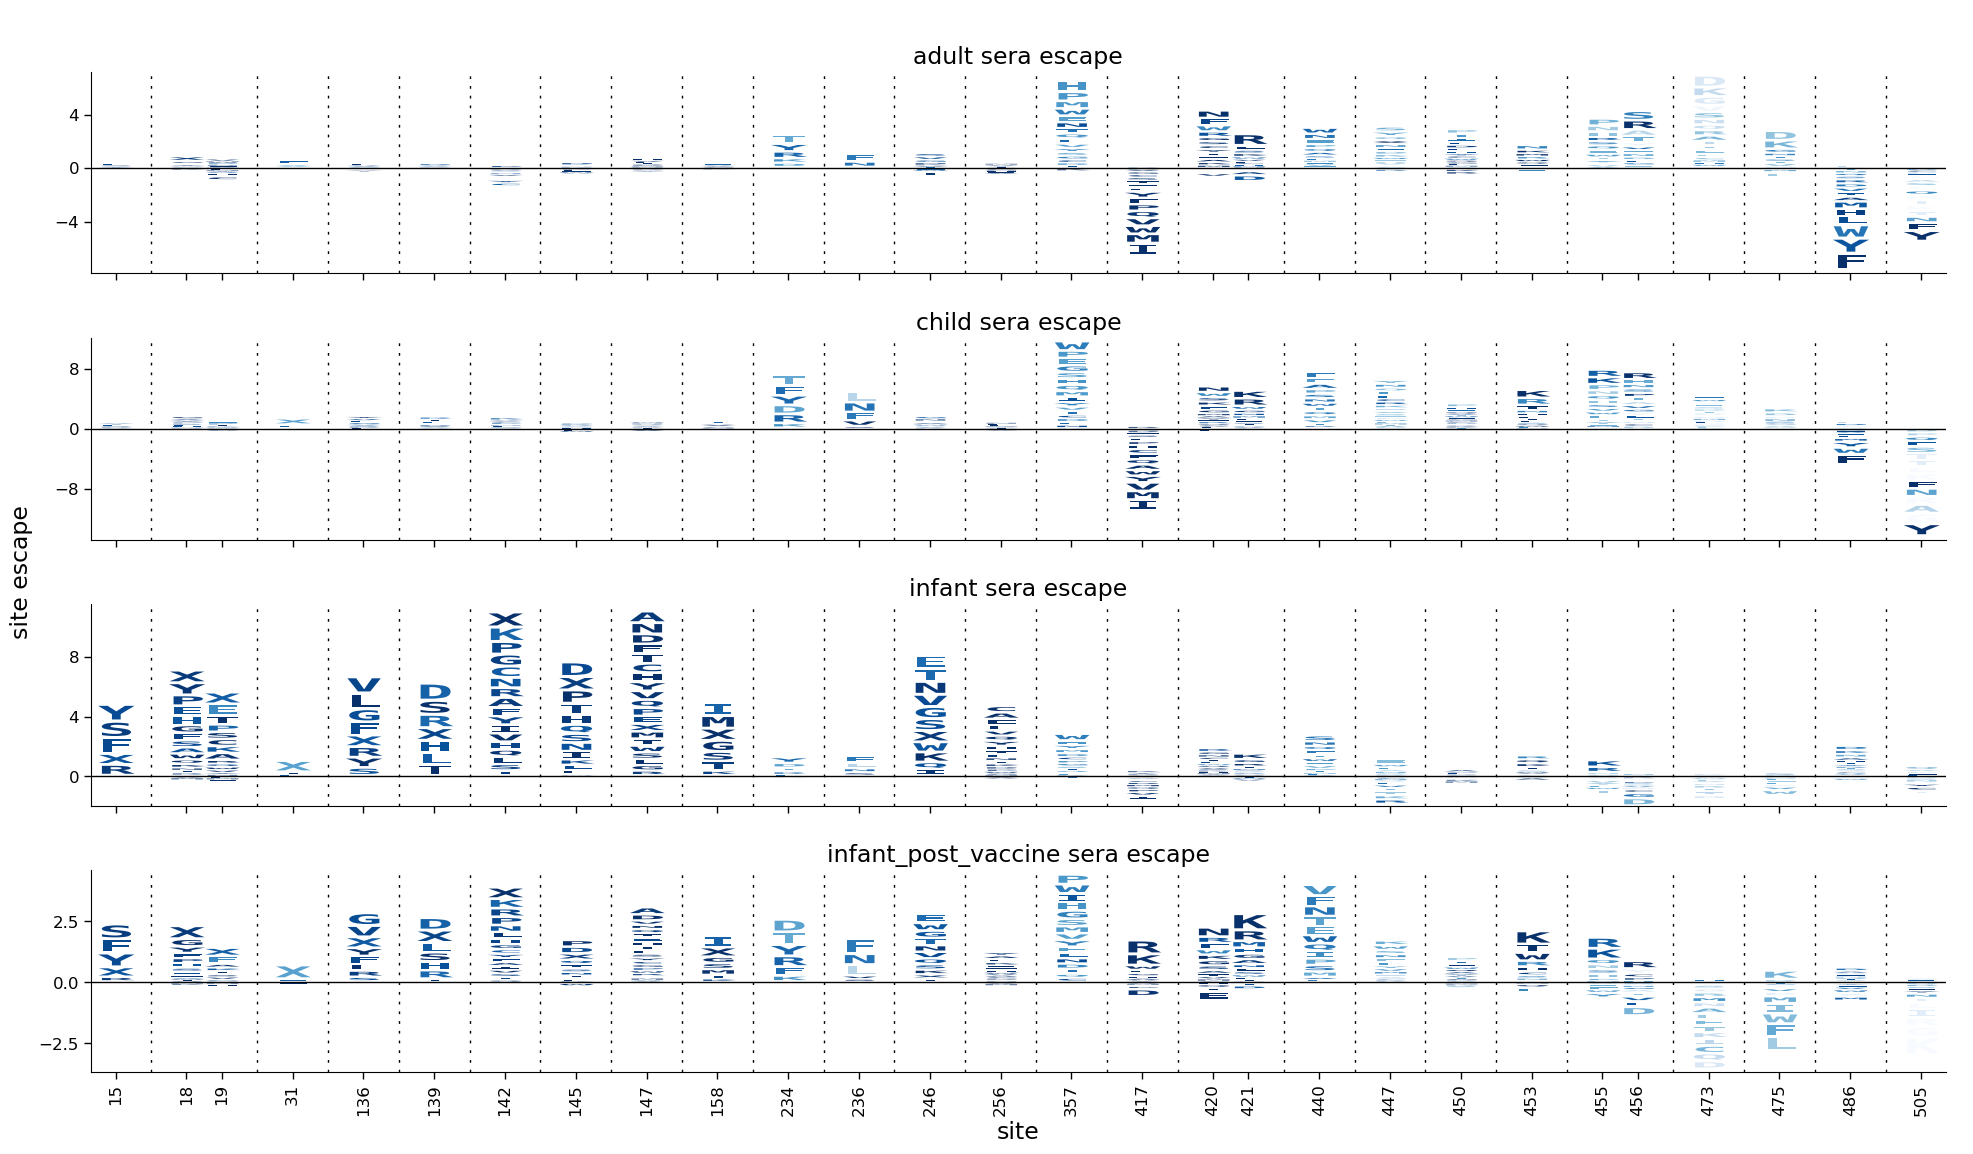

Saving to results/key_sites_colored_ACE2.svg


In [25]:
fig, axes = dmslogo.facet_plot(
    summary_melted,
    show_col="show_site",
    gridrow_col="sera_type",
    x_col="site",
    draw_logo_kwargs={
        "letter_col": "mutant",
        "color_col": "color",
        "letter_height_col": "escape",
        "xtick_col": "site",
        "xlabel": "site",
        "ylabel": "site escape",
        "clip_negative_heights": False,
    },
    share_ylabel=True,
    share_xlabel=False,
    share_ylim_across_rows=False,
)
display(fig)
svg = os.path.join("results",f"key_sites_colored_ACE2.svg")
print(f"Saving to {svg}")
fig.savefig(svg, bbox_inches="tight")
plt.close(fig)